# Confidence intervals

A confidence interval should be interpreted as a varying interval that if computed for different samples from a population, it will contain the real estimand X% of the times. So a 95% confidence interval of a population mean computed using a sample will have the population mean inside it 95% of the times we compute this interval using different samples from the population. **It is not the probability that the estimand lies in this interval. The estimand is fixed and is either in the interval or not.**

[Lecture slides](https://github.com/bcaffo/Caffo-Coursera/blob/master/lecture9.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, chi2, norm, t

## Variance confidence interval
Assuming $S^2$ is the sample variance and $\sigma^2$ is the population variance, $\frac{(n-1)S^2}{\sigma^2}$ belongs to a chi square distribution of $(n-1)$ degrees of freedom. Therefore, we can compute a confidence interval for the variance using the Chi-squared distribution as follows:

$$ \frac{(n-1)S^2}{\chi^2_{n-1, 1-\alpha/2}} \space , \space \frac{(n-1)S^2}{\chi^2_{n-1, \alpha/2}} $$

In the following code blocks, a sample is iteratively drawn from the same population and with the same sample size in each iteration. The confidence interval is computed in each iteration and visualized to demonstrate how the CI should be interpreted, i.e., an interval that contains the estimand X% of the times if the same confidence interval was created using different samples from the same population.

In [2]:
def get_CI(conf_level, s2, n):
    '''
    Get the confidence interval of the population variance.
    
    Parameters:
    -----------
    
    conf_level: float
        Confidence level. Ex: 0.95
        
    s2: float
        Sample variance
    
    n: int
        Number of rv in the sample
    
    '''
    q = 1 - conf_level
    
    # Chi square degrees of freedom
    df = n-1
    
    # See slides
    q1 = chi2.ppf(1-0.5*q, df=df)
    q2 = chi2.ppf(0.5*q, df=df)
    
    
    CI = (df*s2/q1, df*s2/q2)
    
    return CI

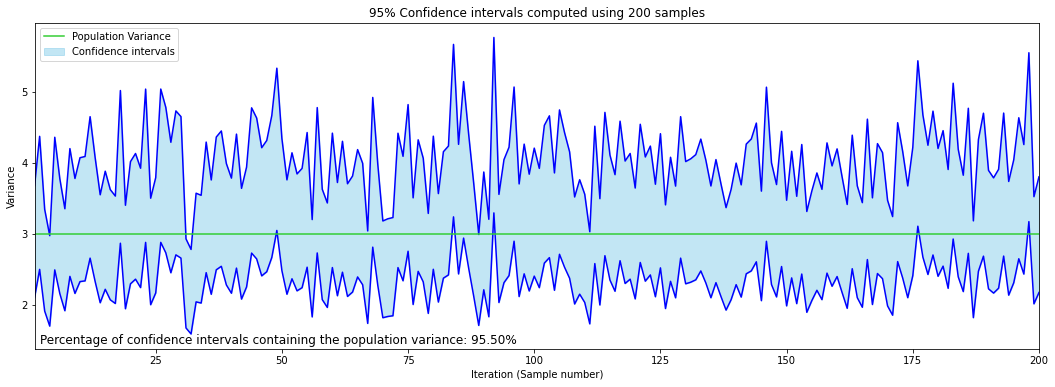

In [3]:
# Generating different samples from a normally distributed population
num_of_trials = 200

n = 100 # Number of RVs in the drawn sample
mu = 0 # Population mean
var = 3 # Population variance
conf_level = 0.95 # Get the 95% CI

lower_bound = np.zeros(num_of_trials)
upper_bound = np.zeros(num_of_trials)

# Count of intervals containing the population variance
count = 0

for i in range(num_of_trials):
    sample = np.random.normal(loc=mu, scale=np.sqrt(var), size=n)
    s2 = sample.var(ddof=1)
    
    CI = get_CI(conf_level, s2, n)
    
    lower_bound[i] = CI[0]
    upper_bound[i] = CI[1]
    
    if var>=CI[0] and var<=CI[1]:
        count += 1

# Plotting

fig, ax = plt.subplots(figsize=(18, 6))

x = np.arange(1, num_of_trials+1)

# Lower bound
ax.plot(x, lower_bound, color='blue')
# Upper bound
ax.plot(x, upper_bound, color='blue')
# Population variance
ax.axhline(y=var, color='limegreen', label='Population Variance')
# Fill between upper and lower bounds
ax.fill_between(x, lower_bound, upper_bound, color='skyblue', alpha=0.5, label='Confidence intervals')

# Annotation
ax.set_xlabel('Iteration (Sample number)')
ax.set_ylabel('Variance')

ax.set_xlim(x.min(), x.max())

title = '{:.0%} Confidence intervals computed using {} samples'.format(conf_level, num_of_trials)
ax.set_title(title)

txt = 'Percentage of confidence intervals containing the population variance: {:.2%}'.format(1.*count/num_of_trials)
y_min, y_max = ax.get_ylim()

ax.text(2, 1.05*y_min, txt, fontsize=12)
ax.legend()
plt.show()

## Student t distribution

A student t distribution is a standard normal distribution divided by the square root of a chi squared distribution divided by its degrees of freedom:
$$ \frac{Z}{\sqrt{\frac{\chi^2}{df}}} = \frac{\bar{x} - \mu}{S/\sqrt{n}} $$

Where:
$ X_1, X_2, ... X_n $ are iid rvs from $ N(\mu, \sigma^2) $

A $(1-\alpha)\times 100$ confidence interval for $\mu$ using the student t interval would be:
$ \bar{X} \pm t_{n-1, 1-\alpha/2} \cdot \frac{S}{\sqrt{n}} $

Applying on the sleep data (See leacture):


In [4]:
difference = np.array([1.2, 2.4, 1.3, 1.3, 0., 1., 1.8, 0.8, 4.6, 1.4])
S = difference.std()
x_bar = difference.mean()
n = len(difference)
df = n-1

In [5]:
CI =x_bar + np.array([-1, 1]) * t.ppf(0.975, df=df) * S / np.sqrt(n)
CI

array([0.74526707, 2.41473293])

### Independent group T confidence intervals

[Lecture Notes](https://github.com/bcaffo/Caffo-Coursera/blob/master/lecture10.pdf)

This is used to compare two independent collections by computing the confidence interval of the mean difference. This can be done in two ways depending on our assumption about the variances:

1. **The population variance is equal for both collections**: In this case, our estimate of the population variance is the pooled variance, which is the average of both vairances weighted by the number of samples in each collection:
$$ S^2_p = \frac{(n_x-1)S_x^2 + (n_y-1)S_y^2}{n_x + n_y - 2} $$
We then create the statistic by dividing a standard normal distribution (normalized by subtracting the population mean from our rv and dividing by the standard error) by the square of a chi-squared distribution, which in this case will have a degree of freedom equal to $n_x + n_y - 2$.


2. **The populations of the two compared collections have different variances**: In this case, the resulting statistic will not explicitly follow a t-distribution, but there is an estimate of the degree of freedom of the t-distribution using the sample variances and sizes that allows us to fit it to a t-distribution and get the confidence interval.

**See notes for more information**

#### Applying on temperature data from different regions in Turkey

Creating samples

In [6]:
import pandas as pd
path = 'data/temperature_data.csv'
df = pd.read_csv(path, parse_dates=[2])

Comparing temperatures in a station in Akdeniz (Mediterranean region) and and a station in Karadeniz (Black sea region)

In [7]:
def get_station_data(data, region):
    i = 0
    while True:
        cond = data['region'] == region
        region_data = data[cond].copy()

        stations = region_data['st_num'].unique()
        st = np.random.choice(stations)

        cond = region_data['st_num'] == st
        region_data = region_data[cond].reset_index(drop=True)
        
        if region_data.shape[0] > 0:
            return region_data

        if i > 10:
            print('region_data not created')
            return None
    
        i += 1

In [8]:
def get_station_data(data, region):
    
    '''
    Get one station's data from the defined region
    '''
    
    cond = data['region'] == region
    region_data = df[cond].copy()

    stations = region_data['st_num'].unique()
    st = np.random.choice(stations)

    cond = region_data['st_num'] == st
    station_data = region_data[cond].reset_index(drop=True)

    return station_data

In [9]:
clusters = ['akdeniz', 'karadeniz']

x1 = get_station_data(df, clusters[0])
x2 = get_station_data(df, clusters[1])

x1 = x1['avg_temp'].to_numpy()
x2 = x2['avg_temp'].to_numpy()

print('Sample 1 size: {}'.format(x1.shape[0]))
print('Sample 2 size: {}'.format(x2.shape[0]))

Sample 1 size: 60
Sample 2 size: 84


#### Case 1: Assuming variance is equal in both populations
In this case our estimator of the two population variances would be the weighted average of both vartiances

In [10]:
def pooled_var(s1, s2):
    '''
    Compute the pooled variance (weighted average) of both variances
    '''
    
    n1 = s1.shape[0]
    var1 = s1.var()
    
    n2 = s2.shape[0]
    var2 = s2.var()
    
    var = ((n1-1)*var1 + (n2-1)*var2) / (n1 + n2 - 2)
    
    return var

In [13]:
n1 = x1.shape[0]
n2 = x2.shape[0]
var = pooled_var(x1, x2)
sig = np.sqrt(var)

We want to find a confidence interval for the difference between the two means. Therefore our variable in this case is $\bar{X1} - \bar{X2}$. The population mean would be $\mu_1 - \mu_2$. And the standard deviation would be $\sqrt{\frac{\sigma^2}{n_1} - \frac{\sigma^2}{n_2}} = \sigma \left(\frac{1}{n_1} - \frac{1}{n_2}\right) ^ {1/2}$.

Then we can say that the statistic that we obtain by dividing the standardized distribution of the mean difference (sample mean difference minus the population mean difference divided by the standard error of the population of mean differences) by the square root of a chi-squared distribution divided by the number of degrees of freedom, follows a student t distribution.

Therefore, the confidence interval of the mean difference would be:
$$ CI_{1-\frac{\alpha}{2}} = \bar{X} - \bar{Y} \pm t_{n_x + n_y - 2, 1-\frac{\alpha}{2}} \cdot S \left(\frac{1}{n_1} - \frac{1}{n_2}\right) ^ {1/2} $$


In [14]:
mean_diff = x1.mean() - x2.mean()
print(f'Observed mean difference: {mean_diff:.3f}')

deg_free = n1 + n2 - 2
q = t.ppf(0.975, deg_free)

CI = mean_diff + np.array([-1, 1]) * q * sig * np.sqrt(1./n1 + 1./n2)
print(f'95% CI: {CI}')

Observed mean difference: 3.899
95% CI: [1.92381817 5.87403897]


The confidence interval of the mean difference does not include zero, meaning that the two samples are significantly different.

Applying on the example from the lecture

In [15]:
n1 = 8
mu1 = 132.86
sig1 = 15.34
var1 = sig1**2

n2 = 21
mu2 = 127.44
sig2 = 18.23
var2 = sig2**2

# Pooled variance
var = ((n1-1)*var1 + (n2-1)*var2) / (n1 + n2 - 2)
sig = np.sqrt(var)

mean_diff = mu1 - mu2
deg_free = n1 + n2 - 2
q = t.ppf(0.975, deg_free)

CI = mean_diff + np.array([-1, 1]) * q * sig * np.sqrt(1./n1 + 1./n2)
CI 

array([-9.52109748, 20.36109748])

#### Case 2: Assuming variances are not equal
In this case the degree of freedom of the statistic can be obtained using the following function. (See lecture notes for the equation)

In [16]:
# Degree of freedom of the student t distribution in the case of unequal variances
def deg_freedom(var1, var2, n1, n2):
    # Variance divided by the number of samples
    sn1 = var1/n1
    sn2 = var2/n2

    df = (sn1 + sn2)**2 / ((sn1**2)/(n1-1) + (sn2**2)/(n2-1))
    
    return df

Applying on the example from the lecture

In [17]:
n1 = 8
mu1 = 132.86
sig1 = 15.34
var1 = sig1**2

n2 = 21
mu2 = 127.44
sig2 = 18.23
var2 = sig2**2

deg_free = deg_freedom(var1, var2, n1, n2)

q = t.ppf(0.975, deg_free)

standard_error = (var1/n1 + var2/n2)**0.5
CI = mean_diff + np.array([-1, 1]) * q * standard_error
CI

array([-8.91332743, 19.75332743])

In [18]:
deg_free

15.035180011917006